In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cbook as cbook
import tensorflow as tf
#import kerastuner as kt
from tensorflow.keras.losses import MeanAbsoluteError
import keras
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
path = r'/content/gdrive/MyDrive/transformed' # use your path
bus_all_files = glob.glob(path + "/bus/*.csv")
car_all_files = glob.glob(path + "/car/*.csv")
pedestrian_all_files = glob.glob(path + "/pedestrian/*.csv")
static_all_files = glob.glob(path + "/static/*.csv")
train_all_files = glob.glob(path + "/train/*.csv") 
all_files=[]
bus_all_files.sort()
all_files = all_files + bus_all_files + car_all_files + pedestrian_all_files + static_all_files + train_all_files


In [ ]:
li_train = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_train.append(df)
frame = pd.concat(li_train, axis=0, ignore_index=True)
frame.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7,7,10,7,7,0,0,310,3,3,...,7.0,7.0,10.0,10.0,0,0,14,7,7,1769
1,7,7,7,10,7,0,0,0,310,3,...,8.0,7.0,7.0,10.0,0,0,0,14,7,2272
2,7,7,7,7,10,0,0,0,0,310,...,8.0,8.0,7.0,7.0,0,0,0,0,14,2549
3,9,7,7,7,7,1757,0,0,0,0,...,10.0,8.0,8.0,7.0,68,0,0,0,0,2674
4,9,9,7,7,7,4216,1757,0,0,0,...,10.0,10.0,8.0,8.0,151,68,0,0,0,2393


In [ ]:
frame.shape

(173308, 46)

# Dealing with Nan Values

In [ ]:
frame.replace('-', np.NaN, inplace = True)
frame.isna().sum().sum()

1412508

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame)
frame = pd.DataFrame(imputed_dataset,columns = frame.columns)
frame.isna().sum().sum()

0

In [ ]:
# LOW - below 1000
# MEDIUM - between 1000 and 4000
# HIGH - greater than 4000

In [ ]:
def categorise(row):  
    if row['DL_bitrate'] <= 1000:
        return 0
    elif row['DL_bitrate'] > 1000 and row['DL_bitrate'] <= 4000:
        return 1
    elif row['DL_bitrate'] > 4000:
        return 2
    return

In [ ]:
frame['Class'] = frame.apply(lambda row: categorise(row), axis=1)

In [ ]:
frame_train = frame.sample(frac = 0.7, random_state=0)
frame_test = frame.drop(frame_train.index)

In [ ]:
frame_train['Class'].value_counts()

2    69925
1    28314
0    23077
Name: Class, dtype: int64

In [ ]:
frame_test['Class'].value_counts()

2    30000
1    12199
0     9793
Name: Class, dtype: int64

In [ ]:
col_names_scaled =['CQI-0', 'CQI-1', 'CQI-2', 'CQI-3', 'CQI-4', 'DL_bitrate-0',
       'DL_bitrate-1', 'DL_bitrate-2', 'DL_bitrate-3', 'DL_bitrate-4', 'SNR-0', 'SNR-1', 'SNR-2', 'SNR-3', 'SNR-4','DL_bitrate']

### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_train[col_names_scaled]

In [ ]:
df = frame_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
X = pd.DataFrame(min_max_scaler.fit_transform(df))
X = X.iloc[: , :-1]

In [ ]:
Y=frame_train['Class']

In [ ]:
'''from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
base_learners = [5, 10, 50, 100, 200,  500, 1000]
depth = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14]
#gamma = [0, 0.1,0.2,0.4,0.8,1.6,3.2,6.4,25.6,102.4]
learning_rate = [0.01, 0.03, 0.06, 0.1]
weights = [1, 10, 25, 50, 99]
param_grid = {'n_estimators': base_learners,'max_depth': depth,  'learning_rate': learning_rate, 'scale_pos_weight': weights}
XGB = XGBClassifier()
model = GridSearchCV(XGB, param_grid, scoring = 'accuracy', cv=5 , n_jobs = -1,pre_dispatch=2)
model.fit(X, Y)
print("Model with best parameters :\n",model.best_estimator_)'''

'from xgboost.sklearn import XGBClassifier\nfrom sklearn.model_selection import GridSearchCV\nbase_learners = [5, 10, 50, 100, 200,  500, 1000]\ndepth = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14]\n#gamma = [0, 0.1,0.2,0.4,0.8,1.6,3.2,6.4,25.6,102.4]\nlearning_rate = [0.01, 0.03, 0.06, 0.1]\nweights = [1, 10, 25, 50, 99]\nparam_grid = {\'n_estimators\': base_learners,\'max_depth\': depth,  \'learning_rate\': learning_rate, \'scale_pos_weight\': weights}\nXGB = XGBClassifier()\nmodel = GridSearchCV(XGB, param_grid, scoring = \'accuracy\', cv=5 , n_jobs = -1,pre_dispatch=2)\nmodel.fit(X, Y)\nprint("Model with best parameters :\n",model.best_estimator_)'

In [ ]:
from xgboost.sklearn import XGBClassifier
model = XGBClassifier(max_depth=5, n_estimators=10,learning_rate=0.01, objective='multi:softmax',class_weight='balanced')
model.fit(X, Y)

XGBClassifier(class_weight='balanced', learning_rate=0.01, max_depth=5,
              n_estimators=10, objective='multi:softprob')

In [ ]:
df_test = frame_test[col_names_scaled]
scaler = MinMaxScaler()
# transform data
X_test = pd.DataFrame(scaler.fit_transform(df_test))
X_test = X_test.iloc[: , :-1]
y_test = frame_test['Class']

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred) 

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.75%


In [ ]:
y_pred

array([0, 1, 1, ..., 2, 2, 2])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
print (cm)

[[ 8067  1629    97]
 [  859  8830  2510]
 [  146  1648 28206]]


In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['Low','Medium','High'], 
                     columns = ['Low','Medium','High'])

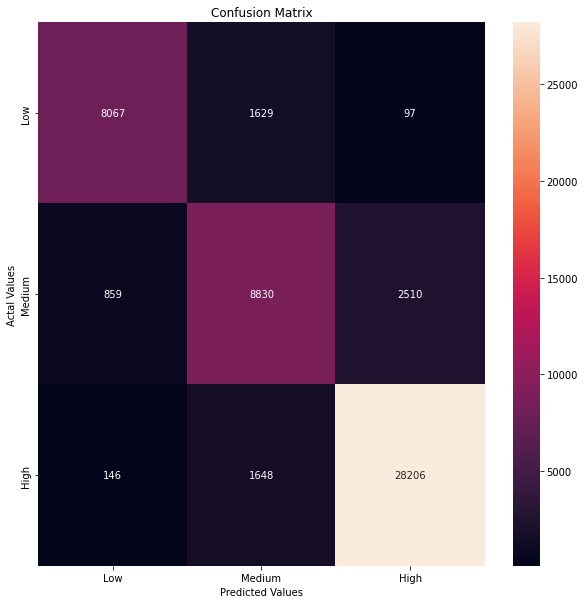

In [ ]:
#Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,fmt='.6g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
#LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(multi_class='multinomial', C= 1000, penalty= 'l2', max_iter=100)
logreg.fit(X,Y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=1000, multi_class='multinomial')

In [ ]:
df_test = frame_test[col_names_scaled]
scaler = MinMaxScaler()
# transform data
X_test = pd.DataFrame(scaler.fit_transform(df_test))
X_test = X_test.iloc[: , :-1]
y_test = frame_test['Class']

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred) 

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.35%


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['Low','Medium','High'], 
                     columns = ['Low','Medium','High'])

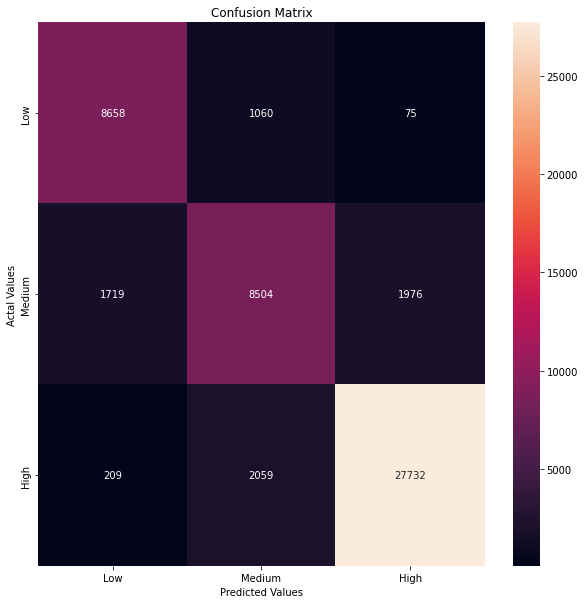

In [ ]:
#Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,fmt='.6g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# Model splitting

In [ ]:
frame_low = frame[frame['DL_bitrate']<=1000]
frame_medium = frame[(frame['DL_bitrate']>1000) & (frame['DL_bitrate']<=4000)]
frame_high = frame[frame['DL_bitrate']>4000]

# low Throughput Model

In [ ]:
frame_low_train = frame_low.sample(frac = 0.7, random_state=0)
frame_low_test = frame_low.drop(frame_low_train.index)

In [ ]:
print(frame_low_train.shape)
print(frame_low_test.shape)

(23009, 47)
(9861, 47)


In [ ]:
df = frame_low_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (16106, 15)
Validation set shape (6903, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
22002,0.491432,0.437705,0.442980,0.438178,0.442533,0.000000,0.000000,0.000000,0.000000,0.000000,0.619884,0.601355,0.598982,0.585723,0.583443
21956,0.488265,0.500000,0.357143,0.285714,0.788959,0.003696,0.023653,0.020637,0.033074,0.041750,0.555556,0.555556,0.612903,0.603175,0.580868
5127,0.478625,0.406706,0.416329,0.412836,0.422115,0.000000,0.000000,0.000000,0.000000,0.000000,0.637583,0.608517,0.606705,0.600740,0.601133
1603,0.498366,0.435873,0.437126,0.436176,0.449646,0.003435,0.000990,0.000743,0.002124,0.002982,0.620180,0.597784,0.595607,0.592285,0.589331
20609,0.516664,0.443311,0.431140,0.427660,0.440492,0.001516,0.000000,0.000000,0.000000,0.000000,0.634076,0.589284,0.590824,0.584548,0.579941


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (16106, 15, 1)
Validation set shape (6903, 15, 1)


In [ ]:
mae = MeanAbsoluteError()
model_low = keras.Sequential()
model_low.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_low.add(Dense(units=480, activation='relu'))
model_low.add(Dropout(rate=0))
model_low.add(tf.keras.layers.Dense(units=224, activation='relu'))
model_low.add(Dropout(rate=0))
model_low.add(tf.keras.layers.Dense(units=128, activation='relu'))
model_low.add(Dropout(rate=0))
model_low.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_low.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_low.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 480)               7680      
                                                                 
 dropout (Dropout)           (None, 480)               0         
                                                                 
 dense_1 (Dense)             (None, 224)               107744    
                                                                 
 dropout_1 (Dropout)         (None, 224)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               28800     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_low.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
504/504 [==============================] - 5s 4ms/step - loss: 0.2140 - mean_absolute_error: 0.2139 - val_loss: 0.1375 - val_mean_absolute_error: 0.1376
Epoch 2/500
504/504 [==============================] - 2s 4ms/step - loss: 0.1241 - mean_absolute_error: 0.1242 - val_loss: 0.1088 - val_mean_absolute_error: 0.1089
Epoch 3/500
504/504 [==============================] - 2s 4ms/step - loss: 0.1090 - mean_absolute_error: 0.1090 - val_loss: 0.1012 - val_mean_absolute_error: 0.1012
Epoch 4/500
504/504 [==============================] - 2s 4ms/step - loss: 0.1056 - mean_absolute_error: 0.1055 - val_loss: 0.1044 - val_mean_absolute_error: 0.1044
Epoch 5/500
504/504 [==============================] - 2s 4ms/step - loss: 0.1036 - mean_absolute_error: 0.1035 - val_loss: 0.1000 - val_mean_absolute_error: 0.1000
Epoch 6/500
504/504 [==============================] - 2s 4ms/step - loss: 0.1024 - mean_absolute_error: 0.1024 - val_loss: 0.0968 - val_mean_absolute_error: 0.0968
Epoch 7/50

In [ ]:
kt_train_pred_min_max_scaled = model_low.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_low.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.1747006208340091
Validation rmse: 0.1695430901534881


In [ ]:
df = frame_low_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.357143,0.428571,0.428571,0.500000,0.357143,0.014106,0.003666,0.002099,0.017551,0.009842,0.476190,0.507937,0.523810,0.507937,0.507937
1,0.357143,0.357143,0.428571,0.428571,0.500000,0.010619,0.015586,0.003666,0.001985,0.016543,0.476190,0.476190,0.507937,0.523810,0.507937
2,0.357143,0.357143,0.357143,0.357143,0.428571,0.013468,0.000172,0.011733,0.014737,0.003267,0.492063,0.492063,0.476190,0.476190,0.507937
3,0.428571,0.428571,0.357143,0.357143,0.500000,0.009825,0.009806,0.006470,0.008442,0.001871,0.476190,0.476190,0.492063,0.492063,0.492063
4,0.428571,0.428571,0.428571,0.428571,0.357143,0.009343,0.006830,0.010856,0.009272,0.005765,0.460317,0.460317,0.476190,0.476190,0.492063


In [ ]:
Y_test = frame_low_test['DL_bitrate']
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_low.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

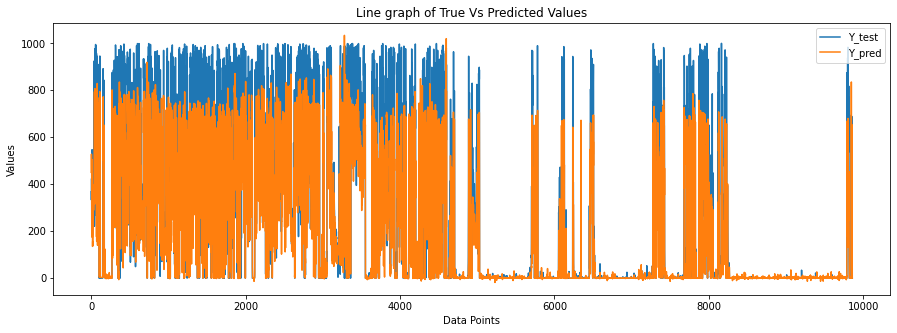

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

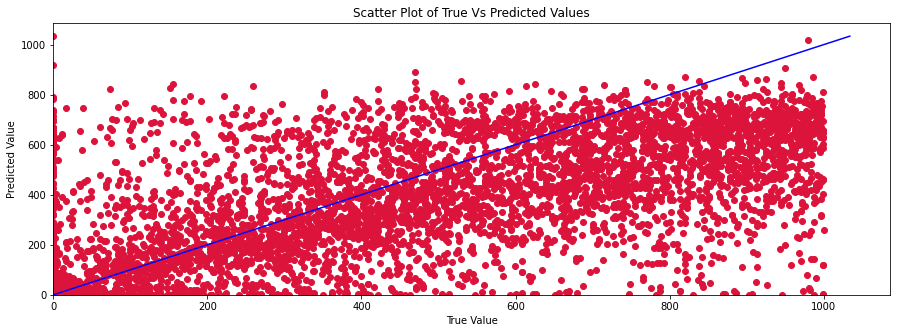

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

In [ ]:
from keras.models import load_model

model_low.save('model_low.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

# Medium Throughput Model

In [ ]:
frame_medium_train = frame_medium.sample(frac = 0.7, random_state=0)
frame_medium_test = frame_medium.drop(frame_medium_train.index)

In [ ]:
print(frame_medium_train.shape)
print(frame_medium_test.shape)

(28359, 47)
(12154, 47)


In [ ]:
df = frame_medium_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (19851, 15)
Validation set shape (8508, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
24469,0.428571,0.428571,0.428571,0.428571,0.428571,0.023053,0.011989,0.021684,0.009670,0.023972,0.383333,0.389831,0.383333,0.423729,0.416667
26120,0.142857,0.357143,0.357143,0.357143,0.357143,0.015039,0.017626,0.012422,0.017567,0.000000,0.433333,0.457627,0.450000,0.457627,0.450000
19277,0.285714,0.285714,0.285714,0.285714,0.285714,0.015754,0.047073,0.048249,0.026403,0.028120,0.433333,0.440678,0.383333,0.389831,0.416667
4655,0.071429,0.142857,0.285714,0.428571,0.428571,0.027512,0.011274,0.001199,0.006443,0.041254,0.500000,0.508475,0.600000,0.610169,0.683333
25810,0.441583,0.438634,0.441880,0.441093,0.442956,0.040679,0.067034,0.062131,0.032975,0.037540,0.652666,0.636516,0.619372,0.630899,0.624160


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (19851, 15, 1)
Validation set shape (8508, 15, 1)


In [ ]:
mae = MeanAbsoluteError()
model_medium = keras.Sequential()
model_medium.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_medium.add(Dense(units=320, activation='relu'))
model_medium.add(Dropout(rate=0))
model_medium.add(tf.keras.layers.Dense(units=256, activation='relu'))
model_medium.add(Dropout(rate=0))
model_medium.add(tf.keras.layers.Dense(units=64, activation='relu'))
model_medium.add(Dropout(rate=0))
model_medium.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_medium.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_medium.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 15)                0         
                                                                 
 dense_4 (Dense)             (None, 320)               5120      
                                                                 
 dropout_3 (Dropout)         (None, 320)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               82176     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_5 (Dropout)         (None, 64)               

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_medium.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
621/621 [==============================] - 3s 4ms/step - loss: 0.2458 - mean_absolute_error: 0.2458 - val_loss: 0.2135 - val_mean_absolute_error: 0.2135
Epoch 2/500
621/621 [==============================] - 2s 4ms/step - loss: 0.1997 - mean_absolute_error: 0.1997 - val_loss: 0.1888 - val_mean_absolute_error: 0.1888
Epoch 3/500
621/621 [==============================] - 2s 4ms/step - loss: 0.1892 - mean_absolute_error: 0.1892 - val_loss: 0.1849 - val_mean_absolute_error: 0.1849
Epoch 4/500
621/621 [==============================] - 2s 4ms/step - loss: 0.1881 - mean_absolute_error: 0.1881 - val_loss: 0.1844 - val_mean_absolute_error: 0.1844
Epoch 5/500
621/621 [==============================] - 2s 4ms/step - loss: 0.1873 - mean_absolute_error: 0.1873 - val_loss: 0.1856 - val_mean_absolute_error: 0.1856
Epoch 6/500
621/621 [==============================] - 2s 4ms/step - loss: 0.1869 - mean_absolute_error: 0.1869 - val_loss: 0.1852 - val_mean_absolute_error: 0.1852
Epoch 7/50

In [ ]:
kt_train_pred_min_max_scaled = model_medium.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_medium.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.23415345414319866
Validation rmse: 0.23292934918706884


In [ ]:
df = frame_medium_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.571429,0.571429,0.571429,0.428571,0.428571,0.069228,0.101554,0.035975,0.000000,0.000000,0.645491,0.615154,0.615547,0.605350,0.534485
1,0.428571,0.571429,0.428571,0.428571,0.500000,0.040130,0.067614,0.048771,0.030007,0.026884,0.606102,0.595912,0.595313,0.646892,0.575278
2,0.428571,0.428571,0.571429,0.428571,0.428571,0.026665,0.040130,0.057473,0.051571,0.014810,0.606102,0.576670,0.595313,0.584579,0.616070
3,0.428571,0.428571,0.428571,0.428571,0.571429,0.052246,0.092111,0.022666,0.036069,0.029993,0.606102,0.576670,0.575078,0.563808,0.554881
4,0.571429,0.428571,0.428571,0.428571,0.428571,0.069228,0.052246,0.078296,0.023967,0.017802,0.625797,0.576670,0.575078,0.563808,0.534485


In [ ]:
Y_test = frame_medium_test['DL_bitrate']
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_medium.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

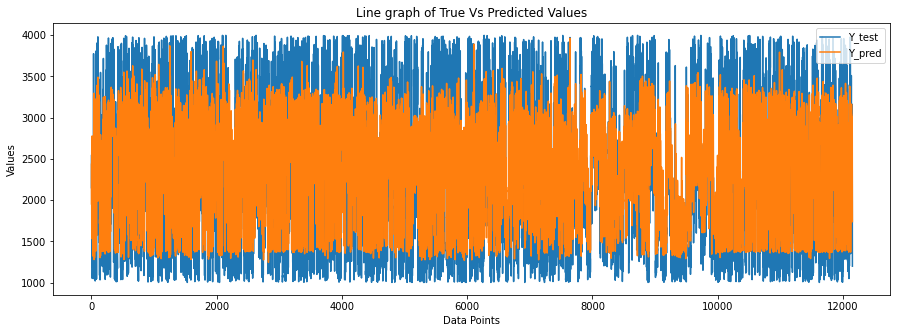

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

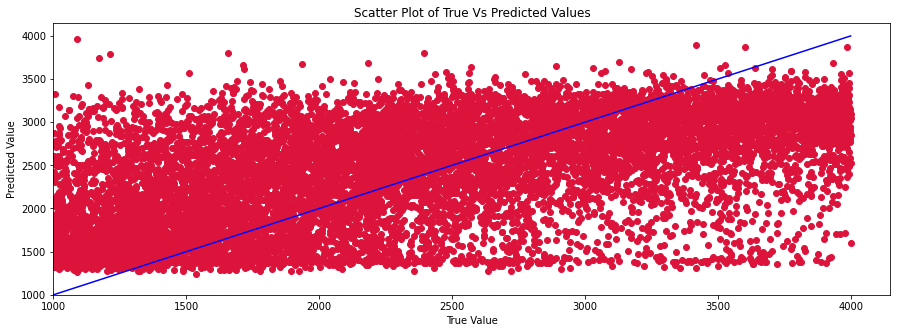

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(1000, None),ylim=(1000, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

In [ ]:
from keras.models import load_model

model_medium.save('model_medium.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

# High Throughput Model

In [ ]:
frame_high_train = frame_high.sample(frac = 0.7, random_state=0)
frame_high_test = frame_high.drop(frame_high_train.index)

In [ ]:
print(frame_high_train.shape)
print(frame_high_test.shape)

(69948, 47)
(29977, 47)


In [ ]:
df = frame_high_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (48963, 15)
Validation set shape (20985, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
22497,0.785714,0.642857,0.642857,0.642857,0.642857,0.257807,0.243157,0.267362,0.240879,0.259084,0.644940,0.604167,0.520833,0.520833,0.562500
62818,0.714286,0.642857,0.714286,0.571429,0.642857,0.179802,0.195600,0.224791,0.204912,0.262291,0.644940,0.604167,0.604167,0.604167,0.562500
33446,0.928571,0.785714,1.000000,1.000000,0.642857,0.490928,0.467356,0.498718,0.486232,0.402649,0.831814,0.812500,0.770833,0.770833,0.645833
43763,0.642857,0.642857,0.642857,0.642857,0.642857,0.021448,0.021975,0.021129,0.032639,0.022756,0.532816,0.479167,0.479167,0.479167,0.479167
60154,0.464193,0.452135,0.457127,0.450656,0.442259,0.057241,0.061081,0.070331,0.070716,0.074626,0.579834,0.502002,0.475187,0.483266,0.468724


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (48963, 15, 1)
Validation set shape (20985, 15, 1)


In [ ]:
mae = MeanAbsoluteError()
model_high = keras.Sequential()
model_high.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_high.add(Dense(units=352, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=352, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=160, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_high.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 15)                0         
                                                                 
 dense_8 (Dense)             (None, 352)               5632      
                                                                 
 dropout_6 (Dropout)         (None, 352)               0         
                                                                 
 dense_9 (Dense)             (None, 352)               124256    
                                                                 
 dropout_7 (Dropout)         (None, 352)               0         
                                                                 
 dense_10 (Dense)            (None, 160)               56480     
                                                                 
 dropout_8 (Dropout)         (None, 160)              

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_high.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
1531/1531 [==============================] - 7s 4ms/step - loss: 0.0271 - mean_absolute_error: 0.0271 - val_loss: 0.0253 - val_mean_absolute_error: 0.0253
Epoch 2/500
1531/1531 [==============================] - 6s 4ms/step - loss: 0.0251 - mean_absolute_error: 0.0251 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249
Epoch 3/500
1531/1531 [==============================] - 6s 4ms/step - loss: 0.0250 - mean_absolute_error: 0.0250 - val_loss: 0.0248 - val_mean_absolute_error: 0.0248
Epoch 4/500
1531/1531 [==============================] - 6s 4ms/step - loss: 0.0248 - mean_absolute_error: 0.0248 - val_loss: 0.0251 - val_mean_absolute_error: 0.0251
Epoch 5/500
1531/1531 [==============================] - 6s 4ms/step - loss: 0.0247 - mean_absolute_error: 0.0247 - val_loss: 0.0263 - val_mean_absolute_error: 0.0263
Epoch 6/500
1531/1531 [==============================] - 6s 4ms/step - loss: 0.0247 - mean_absolute_error: 0.0247 - val_loss: 0.0251 - val_mean_absolute_error: 0.025

In [ ]:
kt_train_pred_min_max_scaled = model_high.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_high.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.03913360033036528
Validation rmse: 0.03941507858829627


In [ ]:
df = frame_high_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.571429,0.571429,0.571429,0.571429,0.571429,0.022171,0.009448,0.009502,0.008066,0.006653,0.416667,0.416667,0.416667,0.375000,0.375000
1,0.500000,0.500000,0.500000,0.500000,0.500000,0.044279,0.041035,0.030830,0.032894,0.037812,0.437500,0.458333,0.437500,0.458333,0.416667
2,0.500000,0.500000,0.500000,0.500000,0.500000,0.066514,0.058277,0.044019,0.047245,0.038459,0.437500,0.437500,0.437500,0.437500,0.458333
3,0.571429,0.571429,0.500000,0.500000,0.500000,0.033159,0.049446,0.072005,0.070969,0.054619,0.479167,0.437500,0.437500,0.437500,0.437500
4,0.357143,0.357143,0.357143,0.071429,0.357143,0.012860,0.000000,0.010080,0.007721,0.001485,0.208333,0.208333,0.104167,0.104167,0.229167


In [ ]:
Y_test = frame_high_test['DL_bitrate']
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

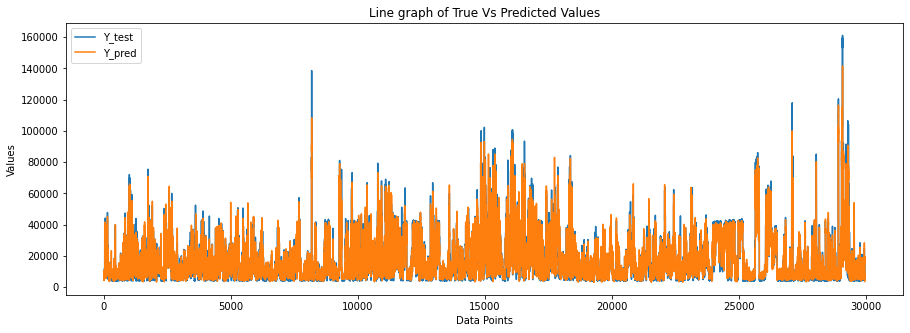

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
from keras.models import load_model

model_high.save('model_high.h5')  # creates a HDF5 file 'my_model.h5'
#model = load_model('my_model.h5')

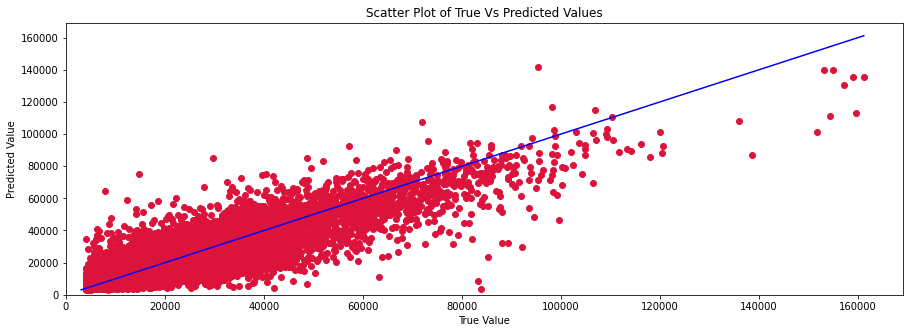

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

In [ ]:
category = model.predict(X_test)

In [ ]:
'''from keras.models import load_model
model_low = load_model('/content/model_low.h5')
model_medium = load_model('/content/model_medium.h5')
model_high = load_model('/content/model_high.h5')'''

"from keras.models import load_model\nmodel_low = load_model('/content/model_low.h5')\nmodel_medium = load_model('/content/model_medium.h5')\nmodel_high = load_model('/content/model_high.h5')"

In [ ]:
X_test[15]=category

In [ ]:
X_test_low = X_test[(X_test[15] == 0)]
X_test_medium = X_test[(X_test[15] == 1)]
X_test_high = X_test[(X_test[15] == 2)]

In [ ]:
X_test_low.drop([15],axis=1,inplace=True)
X_test_medium.drop([15],axis=1,inplace=True)
X_test_high.drop([15],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X_test.drop([15],axis=1,inplace=True)

In [ ]:
l=[]
for idx, row in X_test.iterrows():
    if(category[idx]==0):
      l.append(model_low.predict(row.to_numpy().reshape(1,-1)).reshape(-1).tolist())
    if(category[idx]==1):
      l.append(model_medium.predict(row.to_numpy().reshape(1,-1)).reshape(-1).tolist())
    if(category[idx]==2):
      l.append(model_high.predict(row.to_numpy().reshape(1,-1)).reshape(-1).tolist())  

In [ ]:
from functools import reduce
import operator
out = reduce(operator.concat, l)

In [ ]:
X_test[15]=out

In [ ]:
df_test = pd.DataFrame(min_max_scaler.inverse_transform(X_test))
Y_pred = df_test.iloc[:,-1:]

In [ ]:
Y_test = frame_test['DL_bitrate']
Y_test.reset_index(drop=True,inplace=True)

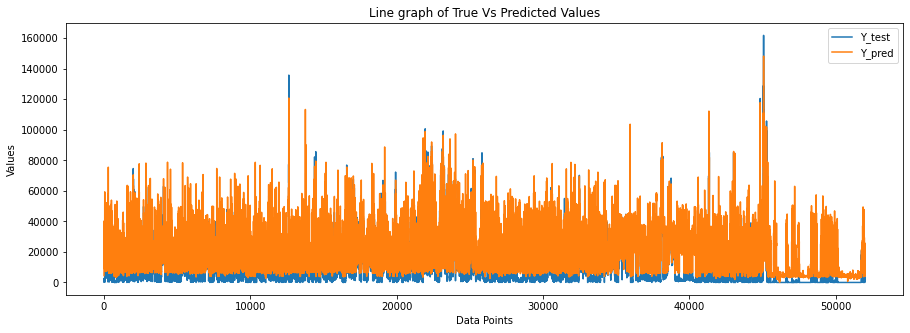

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

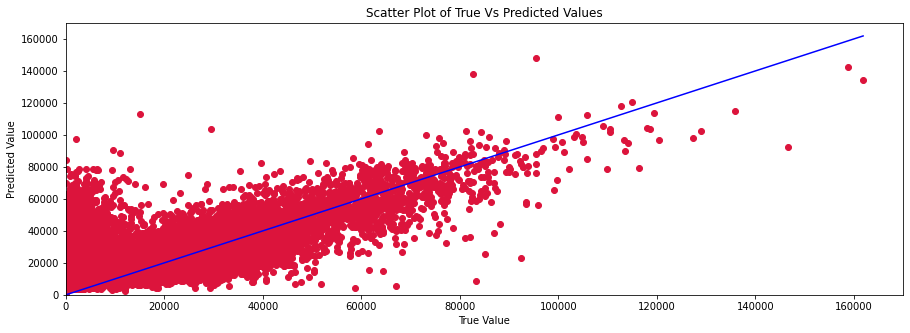

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

In [ ]:
Y_pred_series = Y_pred[15]

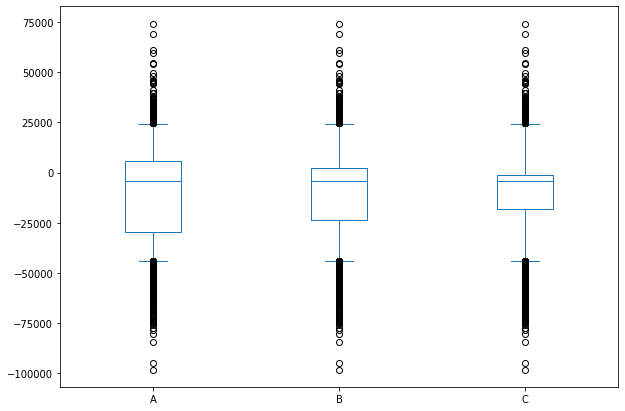

In [ ]:
a=Y_test.subtract(Y_pred_series)
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred_series

In [ ]:
Y_test

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred_series)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred_series)

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred_series)